Notes

- I installed snorkel from the redux branch on 7 Aug into an environment running Python 3.6 -- 3.5 and 3.7 both didn't work for me. Skimming the git issues seems to indicate this is going to be fixed.
- Snorkel developers are working on a new release - "coming later this summer" - so it may soon be better to install from master or just with pip/conda
- For data, I'm using the version of the Global Terrorism Database on Kaggle (https://www.kaggle.com/START-UMD/gtd/)

Beware of blogs, etc. about snorkel which may be helpful but often discuss outdated versions of the API!
- These tutorials WERE helpful, and then they got deleted: https://github.com/HazyResearch/snorkel/tree/redux/tutorials/workshop.
- Avoid these tutorials, which are outdated: https://github.com/HazyResearch/snorkel/blob/master/tutorials
- These tutorials seem to be up-to-date. I recommend the YouTube spam tutorial for basics on text classification: https://github.com/snorkel-team/snorkel-tutorials/blob/master

In [1]:
import pandas as pd
import numpy as np
import snorkel
import re 

from sklearn.model_selection import train_test_split

In [2]:
terror_df = pd.read_csv('/Users/awhite/Documents/globalterrorismdb_0718dist.csv',
                       encoding = 'ISO-8859-1')

/anaconda3/envs/snorkel2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
terror_df.summary.head(20)

0                                                   NaN
1                                                   NaN
2                                                   NaN
3                                                   NaN
4                                                   NaN
5     1/1/1970: Unknown African American assailants ...
6                                                   NaN
7     1/2/1970: Unknown perpetrators detonated explo...
8     1/2/1970: Karl Armstrong, a member of the New ...
9     1/3/1970: Karl Armstrong, a member of the New ...
10                                                  NaN
11    1/6/1970: Unknown perpetrators threw a Molotov...
12                                                  NaN
13    1/9/1970: Unknown perpetrators set off a fireb...
14    1/9/1970:  The Armed Commandos of Liberation c...
15                                                  NaN
16                                                  NaN
17    1/12/1970: Unknown perpetrators threw a pi

In [6]:
#drop items w no summary
terror_df = terror_df.dropna(subset=['summary'])
len(terror_df)

115562

In [7]:
train, test = train_test_split(terror_df, test_size = 0.2, random_state = 0)

#snorkel calls for a separate validation set (and optionally a dev set for LF development)
train, valid = train_test_split(train, test_size = 0.2, random_state = 0)

Y_train = train["suicide"].values
Y_valid = valid["suicide"].values
Y_test = test["suicide"].values

In [8]:
len(test)

23113

Let's try to predict if an attack was a suicide attack - this seems easy.

In [9]:
pd.set_option("display.max_colwidth", 0)

terror_df[terror_df.suicide == 1].summary.sample(5, random_state=3)

76962    09/04/2004: A Police Academy in Kirkuk Iraq was attacked by a suicide bomber in a car, killing 20 and wounding 36. Tawhid and Jihad claimed responsibility for the attack.                                                                                                                                                                                                                                                                                       
76226    01/18/2004: A pickup truck loaded with 500 kilos of explosives exploded at the Assassin's Gate, the entrance to the main industrial center of Baghdad, Iraq, and also the United States' Military headquarters. Twenty-five were people killed and over 100 were injured in the attack, for which no group claimed responsibility.                                                                                                                               
77565    02/24/2005: An unidentified suicide car bomber wearing a police uniform t

In [10]:
terror_df[terror_df.suicide == 0].summary.sample(5, random_state=3)

112007    10/30/2012: Assailants detonated an explosive device at an electricity tower in the Ghitani area of Mach town, Balochistan province, Pakistan. There were no reported casualties; however, the targeted tower was partially damaged in the blast. No group claimed responsibility for the incident.                                                                                                               
156272    12/05/2015: An explosive device detonated as police personnel were attempting to defuse it in Waghaz district, Ghazni Province, Afghanistan. Two police officers were wounded in the blast. No group claimed responsibility for the incident.                                                                                                                                                                     
158353    01/31/2016: Explosive devices detonated targeting a military patrol in eastern Norte de Santander department, Colombia. Two soldiers were killed in the blast. No gr

In [11]:
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function
from snorkel.types import DataPoint

POS = 1
NEG = 0 
ABSTAIN = -1

In [13]:
train.summary.str.contains("suicide attack").value_counts()

False    73772
True     187  
Name: summary, dtype: int64

It seems snorkel isn't very forgiving about the way you write LFs. I tried a number of different ways for these basic examples - find a substring in text - and couldn't get them to work until I copied the approach in https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb. For instance `str.contains()` and `str.count()` didn't work. Maybe I was doing something wrong.

While there is some disagreement on this, snorkel developers generally suggest that many simple LFs are better than a few complex LFs.

In [14]:
@labeling_function()
def suicide_mentioned(x):
    return POS if "suicide" in x.summary.lower() else ABSTAIN

In [15]:
@labeling_function()
def suicide_attack(x):
    return POS if "suicide attack" in x.summary.lower() else ABSTAIN

In [16]:
@labeling_function()
def suicide_bomb(x):
    return POS if "suicide bomb" in x.summary.lower() else ABSTAIN

In [17]:
@labeling_function()
def unknown_perps(x):
    return NEG if "unknown perpetrator" in x.summary.lower() else ABSTAIN

In [18]:
@labeling_function()
def no_responsibility(x):
    return NEG if "no group claimed responsibility" in x.summary.lower() else ABSTAIN

`PandasLFApplier` is what it sounds like - a snorkel tool for applying LFs to a pandas df

In [19]:
lfs = [suicide_mentioned,suicide_attack,
       suicide_bomb,unknown_perps,
       no_responsibility]

applier = PandasLFApplier(lfs)

L_train = applier.apply(df=train)
L_valid = applier.apply(df=valid)
L_test = applier.apply(df=test)

100%|██████████| 23113/23113 [00:03<00:00, 6852.17it/s]


In [20]:
from snorkel.labeling.analysis import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
suicide_mentioned,0,[1],0.053678,0.051082,0.025392
suicide_attack,1,[1],0.002555,0.002555,0.001028
suicide_bomb,2,[1],0.048581,0.048581,0.023540
unknown_perps,3,[0],0.016104,0.001176,0.000041
no_responsibility,4,[0],0.658203,0.026488,0.025352


If you supply gold labels, snorkel calculates empirical accuracy for you. We're cheating here by using training set labels, but this is the purpose of the dev set - a small pool of data that is labeled, possibly just by hand.

https://medium.com/sculpt/a-technique-for-building-nlp-classifiers-efficiently-with-transfer-learning-and-weak-supervision-a8e2f21ca9c8 is a good resource here - the author talks about hand-labeling data and building LFs when using snorkel to identify anti-semitic tweets.

In [23]:
#If you supply gold labels, snorkel calculates empirical accuracy for you!
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
suicide_mentioned,0,[1],0.053678,0.051082,0.025392,3878,92,0.976826
suicide_attack,1,[1],0.002555,0.002555,0.001028,180,9,0.952381
suicide_bomb,2,[1],0.048581,0.048581,0.023540,3535,58,0.983858
unknown_perps,3,[0],0.016104,0.001176,0.000041,1188,3,0.997481
no_responsibility,4,[0],0.658203,0.026488,0.025352,46764,1916,0.960641


So in theory we should stop here, because LFs by themselves give good accuracy. Or, if the description says suicide bomber...it's probably a suicide bomber. But let's work through to the end for fun.

In [24]:
#First, let's try a simple majority vote approach
from snorkel.labeling.model import MajorityLabelVoter

In [25]:
majority_model = MajorityLabelVoter()
Y_pred_train = majority_model.predict(L=L_train)
Y_pred_train

array([0, 1, 0, ..., 0, 0, 0])

In [26]:
majority_acc = majority_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   85.2%


In [27]:
#Let's use snorkel's model for probabilistic labels and train a classifier 
from snorkel.labeling.model import LabelModel

In [28]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=1000, lr=0.001, log_freq=100, seed=123)

In [29]:
label_model_acc = label_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     83.7%


The label model usually outperforms the majority vote model - that isn't the case here because we have a few super accurate LFs. Snorkel also warns against using the label model for prediction: 

>it is typically not suitable as an inference-time model to make predictions for unseen examples, due to (among other things) some data points having all abstain labels. 

Next, let's check to be sure the labels are probabilistic.

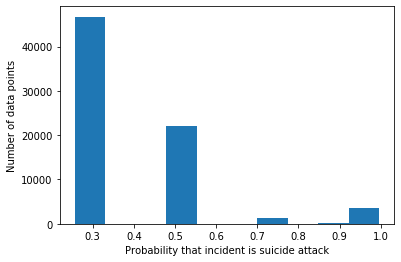

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability that incident is suicide attack")
    plt.ylabel("Number of data points")
    plt.show()

Y_probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(Y_probs_train[:, 1])

The original dataset is unbalanced so that looks about right.

`filtered_unlabeled_dataframe` cuts any rows that didn't get labels from the training set, as another way to boost performance. It's mentioned in the snorkel tutorials but the function is not exactly where the tutorials claim - I found this and `probs_to_pred` by searching for the functions in the snorkel GH. This code might not run in the future if snorkel is updated to match the tutorial.

In [31]:
from snorkel.labeling.utils import filter_unlabeled_dataframe

train_filtered, Y_probs_train_filtered = filter_unlabeled_dataframe(
    X=train, y=Y_probs_train, L=L_train
)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

words_train = [row.summary for i, row in train_filtered.iterrows()]
words_valid = [row.summary for i, row in valid.iterrows()]
words_test = [row.summary for i, row in test.iterrows()]

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(words_train)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

sklearn doesn't accept probabilistic labels, so snorkel provides a helper function to replace each label distribution with the label of the class that has the maximum probability. This is less good, but let's try for now.

In [33]:
from snorkel.analysis.utils import probs_to_preds
Y_preds_train_filtered = probs_to_preds(probs=Y_probs_train_filtered)

In [34]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB().fit(X_train, Y_preds_train_filtered)

In [35]:
predicted = classifier.predict(X_test)
np.mean(predicted == Y_test)           

0.9391251676545667

In [36]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier().fit(X_train, Y_preds_train_filtered)

predicted = classifier.predict(X_test)
np.mean(predicted == Y_test)

0.9710985159866742

So we're close to the performance of individual LFs...but not quite there.

Finally, let's quickly test snorkel's claim that dropping unlabeled items boosts performance.

In [39]:
Y_preds_train = probs_to_preds(probs=Y_probs_train)

words_train = [row.summary for i, row in train.iterrows()]
words_valid = [row.summary for i, row in valid.iterrows()]
words_test = [row.summary for i, row in test.iterrows()]

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(words_train)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

In [42]:
classifier = SGDClassifier().fit(X_train, Y_preds_train)

predicted = classifier.predict(X_test)
np.mean(predicted == Y_test)

0.9711850473759356

At least in this case, basically the same performance.